# Experimenting with Maximum Likelihood Parameter Estimation (MLE)
## Problem description:
A ball is dropped and accelerates without drag. The position of the ball is measured including some measurement noice. We want to use a well known differential equation to determine the unknown coefficient (gravity) using Maximum Likelihood Parameter Estimation.

## Constraits:
We want to solve the diff. eq. numerically by running a "simulation" when we don't know an analytical solution describing the position of the ball.

## Solutions:
Solution1: Measured acceleration is calculated numerically from the measured positions. The Measured acceleration can then be used to fit the parameters of the diff. eq.

Somution2: Estimated Position is calculated by solving the differential equation (simulating) for parameter guess.

In [13]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.integrate import odeint

## Generate data for a ball drop

In [14]:
def calculate_force(g, m):
    #return g*m - cd*u**2
    return g*m

def calculate_acceleration(g):
    return calculate_force(g=g, m=1)

def ball_drop_air(states, t, g):
    
    # states:
    # [x,u]
        
    x = states[0]
    u = states[1]
    dxdt = u
    
    dudt = calculate_acceleration(g=g)
    
    d_states_dt = np.array([dxdt,dudt])
    
    return d_states_dt

In [15]:
def simulate(states_0, t, g):
    states = odeint(func = ball_drop_air,y0 = states_0,t = t,args=(g,))
    return states

In [16]:
states_0 = np.array([0,0])
t = np.linspace(0,10,100)
g=9.81
m = 1
cd = 0.01
states = simulate(states_0=states_0,t = t, g=g)

In [17]:
x = states[:,0]
dxdt = states[:,1]

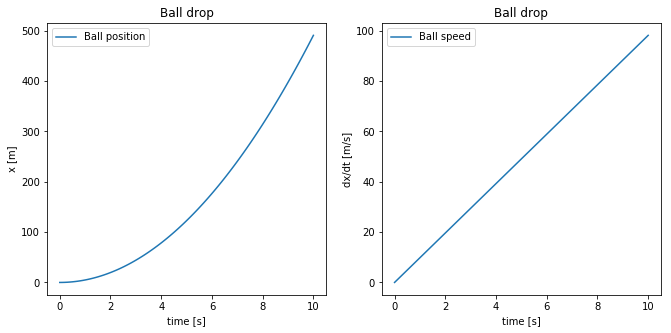

In [18]:
fig,axes = plt.subplots(ncols = 2)
fig.set_size_inches(11,5)
ax = axes[0]
ax.plot(t,x,label = 'Ball position')

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
a = ax.legend()

ax = axes[1]
ax.plot(t,dxdt,label = 'Ball speed')

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('dx/dt [m/s]')
a = ax.legend()

## Add measurement noice

In [19]:
ϵ = np.random.normal(loc = 0.0, scale = 4.0, size = len(x))
x_measure = x + ϵ

In [20]:
v_measure = np.gradient(x_measure,t)
a_measure = np.gradient(v_measure,t)

In [21]:
df = pd.DataFrame({'t':t, 'x':x_measure, 'v':v_measure, 'a':a_measure})

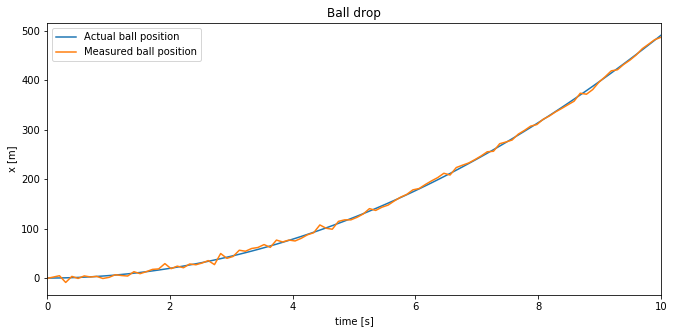

In [22]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)
ax.plot(t,x, label = 'Actual ball position')
df.plot(x='t', y='x', label = 'Measured ball position', ax=ax)
ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()

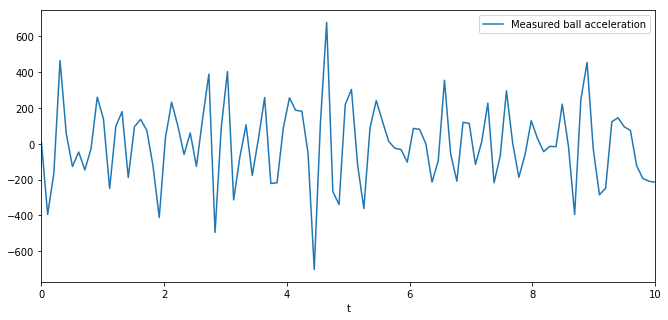

In [23]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)
df.plot(x='t', y='a', ax=ax, label='Measured ball acceleration')

# Solution 1
Calculating the acceleration numerically from measured position. This gives a very bad prediction of unknown coefficeient (gravity).

## Maximum Likelihood 

### define likelihood function


In [28]:
def MLERegression(params):
    
    g, std = params[0], params[1] # inputs are guesses at our parameters
    
    t = None
    
    ahat = calculate_acceleration(g=g)
    
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(a_measure, loc=ahat, scale=std) )
    # return negative LL
    return(negLL)

In [29]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,10])
results = minimize(MLERegression, guess, method = 'Nelder-Mead', 
          options={'disp': True})

Optimization terminated successfully.
         Current function value: 681.802936
         Iterations: 75
         Function evaluations: 144


In [30]:
results

 final_simplex: (array([[  1.13522841, 221.20519518],
       [  1.13525342, 221.20525806],
       [  1.1353053 , 221.20523954]]), array([681.80293608, 681.80293608, 681.80293608]))
           fun: 681.8029360814297
       message: 'Optimization terminated successfully.'
          nfev: 144
           nit: 75
        status: 0
       success: True
             x: array([  1.13522841, 221.20519518])

In [31]:
coefficients = results['x'][0:-1]
g_pred = coefficients[0]
g_pred

1.1352284126810641

# Solution 2 
Estimated Position is calculated by solving the differential equation (simulating) for parameter guess.

In [32]:
def MLERegression2(params):
    
    v_0, a_0, g, std = params[0], params[1], params[2], params[3] # inputs are guesses at our parameters
    
    states_0 = [v_0, a_0]
    states = simulate(states_0, t, g)
    xhat = states[:,0]
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(x_measure, loc=xhat, scale=std) )
    # return negative LL
    return(negLL)

In [33]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([0, 0, 5, 10])
results = minimize(MLERegression2, guess, method = 'Nelder-Mead', 
          options={'disp': True})

Optimization terminated successfully.
         Current function value: 276.606063
         Iterations: 249
         Function evaluations: 429


In [34]:
results

 final_simplex: (array([[-0.19497397,  0.59041324,  9.67059734,  3.84636255],
       [-0.195006  ,  0.59050924,  9.67057661,  3.84639072],
       [-0.19499562,  0.59047824,  9.67057942,  3.84635379],
       [-0.19498035,  0.59043245,  9.67059542,  3.84631923],
       [-0.19500292,  0.59050017,  9.67057978,  3.84630137]]), array([276.60606324, 276.60606325, 276.60606325, 276.60606325,
       276.60606328]))
           fun: 276.60606323730025
       message: 'Optimization terminated successfully.'
          nfev: 429
           nit: 249
        status: 0
       success: True
             x: array([-0.19497397,  0.59041324,  9.67059734,  3.84636255])

In [35]:
coefficients = results['x']

In [36]:
states_0_pred = coefficients[0:2]
g_pred = coefficients[2]
states_pred = simulate(states_0=states_0_pred,t = t, g=g_pred)
x_pred = states_pred[:,0]
v_pred = states_pred[:,1]


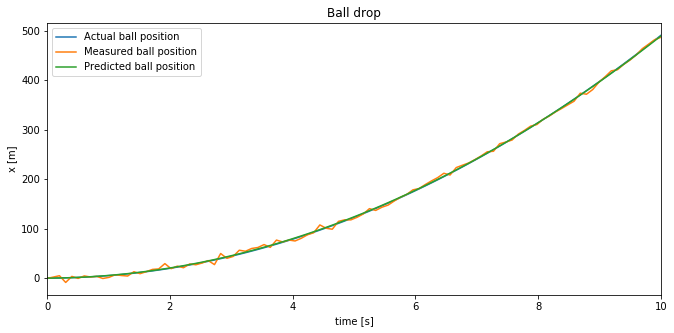

In [37]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)
ax.plot(t,x, label = 'Actual ball position')
df.plot(x='t', y='x', label = 'Measured ball position', ax=ax)
ax.plot(t,x_pred, label = 'Predicted ball position')
ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()